## Data pre-processing and augmentation ( Experimental )

In [1]:
#Reference: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
from __future__ import print_function, division
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model, load_model, model_from_yaml
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

import os
%matplotlib inline 

import matplotlib.pyplot as plt
from PIL import Image
from ipywidgets import interact
from scipy.misc import imresize, imsave
from shutil import copyfile
from skimage.segmentation import mark_boundaries

import numpy as np
import random
import os
import glob
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv
import random

# importing "Skater" related functions
from skater.util.image_ops import load_image, show_image, normalize, add_noise, flip_pixels, image_transformation
from skater.util.image_ops import in_between, greater_than, greater_than_or_equal, equal_to
from skater.core.local_interpretation.dnni.deep_interpreter import DeepInterpreter
from skater.core.visualizer.image_relevance_visualizer import visualize

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


## Initialization

In [2]:
# image dimension of the input images
img_width, img_height = 150, 150

# Download the data from Kaggle https://www.kaggle.com/c/dogs-vs-cats/data?train.zip
# Binary classification problem : [(1=dog); (0=cat)]
# One can do it from CLI using Curl 
## e.g. 1. wget -x -c --load-cookies cookies.txt -nH --cut-dirs=5 https://www.kaggle.com/c/dogs-vs-cats/download/train.zip
##      2. create train and validation folders and respectively unzip the downloaded files
train_data_dir = '../../data/dogs_vs_cats/train'
validation_data_dir = '../../data/dogs_vs_cats/validation'
path = '../../'

# Experiment initialization:
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

In [3]:
from random import randint
def browse_images(dir_path, define_range=10):
    list_of_images = os.listdir(dir_path)
    n = len(list_of_images)
    if define_range > n:
        raise ValueError("out of range")
    def view_image(index):
        im = Image.open('{}{}'.format(dir_path, list_of_images[index]))
        plt.imshow(im, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.show()
    interact(view_image, index=(0, define_range))

# Quick Exploration of the images

In [4]:
# Explore the dog pictures
browse_images('../../data/dogs_vs_cats/train/dog/')

A Jupyter Widget

In [5]:
# Explore the cat pictures
browse_images('../../data/dogs_vs_cats/train/cat/')

A Jupyter Widget

## Selecting Backend - Tensorflow or Theano

In [6]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
input_shape

(150, 150, 3)

In [7]:
browse_images('../../data/dogs_vs_cats/preview/')

A Jupyter Widget

## Model Architecture

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Data pre-processing

In [9]:
# TODO: Stream-line splitting of train and test in a better way
# Make sure to check on the read/write permission for the training_set/validation_set directories. 
# chmod -R 777 ../data/dogs_vs_cats/train/training_set/dog/
# chmod -R 777 ../data/dogs_vs_cats/train/validation_set/dog/
# chmod -R 777 ../data/dogs_vs_cats/train/training_set/cat/

_image_list_dog = os.listdir('{}data/dogs_vs_cats/train/dog/'.format(path))
image_index_list_dog = random.sample(range(len(_image_list_dog)), k=2500)
#os.mkdir('{}data/dogs_vs_cats/train/training_set/dog'.format(path), 755)
#os.mkdir('{}data/dogs_vs_cats/train/validation_set/dog'.format(path), 755)

_image_list_cat = os.listdir('{}data/dogs_vs_cats/train/cat/'.format(path))
image_index_list_cat = random.sample(range(len(_image_list_cat)), k=2500)
#os.mkdir('{}data/dogs_vs_cats/train/training_set/cat'.format(path), 755)
#os.mkdir('{}data/dogs_vs_cats/train/validation_set/cat'.format(path), 755)

In [10]:
train_test_split = 0.8
train_split = int(train_test_split*2500)
test_split = int(train_test_split*2500)
image_index_list_dog_train, image_index_list_dog_test = image_index_list_dog[:train_split], image_index_list_dog[train_split:]
image_index_list_cat_train, image_index_list_cat_test = image_index_list_cat[:train_split], image_index_list_cat[train_split:]

In [11]:
def copy_files(image_index_list, file_list, src, dst):
    for index in image_index_list:
        image_name = file_list[index]
        #src_path = os.path.join(os.getcwd(),src, image_name)
        #dst_path = os.path.join(os.getcwd(), dst, image_name)
        copyfile(src+image_name, dst+image_name)

In [12]:
# Training set 
# Once the directories are created, one can skip the execution of this cell.
# More work is needed in handing the directories for it to be fully automated

copy_files(image_index_list_dog_train, _image_list_dog, src='{}data/dogs_vs_cats/train/dog/'.format(path), 
           dst='{}data/dogs_vs_cats/train/training_set/dog/'.format(path))
copy_files(image_index_list_cat_train, _image_list_cat, src='{}data/dogs_vs_cats/train/cat/'.format(path), 
           dst='{}data/dogs_vs_cats/train/training_set/cat/'.format(path))

# Testing set
copy_files(image_index_list_dog_test, _image_list_dog, src='{}data/dogs_vs_cats/train/dog/'.format(path), 
           dst='{}data/dogs_vs_cats/train/validation_set/dog/'.format(path))
copy_files(image_index_list_cat_test, _image_list_cat, src='{}data/dogs_vs_cats/train/cat/'.format(path), 
           dst='{}data/dogs_vs_cats/train/validation_set/cat/'.format(path))

In [13]:
batch_size = 16

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

print("Training set..")
train_generator = train_datagen.flow_from_directory(
        '{}data/dogs_vs_cats/train/training_set/'.format(path),  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

print("Validation set ...")
validation_generator = test_datagen.flow_from_directory(
        '{}data/dogs_vs_cats/train/validation_set/'.format(path),
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Training set..
Found 18827 images belonging to 2 classes.
Validation set ...
Found 6946 images belonging to 2 classes.


## Model Training

In [28]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
125/125 [==============================] - 35s - loss: 0.7058 - acc: 0.5350 - val_loss: 0.6572 - val_acc: 0.6012
Epoch 2/50
125/125 [==============================] - 34s - loss: 0.6652 - acc: 0.6065 - val_loss: 0.6208 - val_acc: 0.6737
Epoch 3/50
125/125 [==============================] - 34s - loss: 0.6406 - acc: 0.6400 - val_loss: 0.6123 - val_acc: 0.6553
Epoch 4/50
125/125 [==============================] - 34s - loss: 0.6185 - acc: 0.6617 - val_loss: 0.5774 - val_acc: 0.7137
Epoch 5/50
125/125 [==============================] - 34s - loss: 0.6052 - acc: 0.6730 - val_loss: 0.5474 - val_acc: 0.7389
Epoch 6/50
125/125 [==============================] - 34s - loss: 0.5844 - acc: 0.6965 - val_loss: 0.6639 - val_acc: 0.6687
Epoch 7/50
125/125 [==============================] - 34s - loss: 0.5784 - acc: 0.7000 - val_loss: 0.5252 - val_acc: 0.7350
Epoch 8/50
125/125 [==============================] - 34s - loss: 0.5852 - acc: 0.7029 - val_loss: 0.5700 - val_acc: 0.7136
Epoch 9/

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
__________

### Persist the model for future use

In [30]:
# Persist the mode
model_yaml = model.to_yaml()
with open("model_cats_dogs.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model_cats_dogs.h5")
print("Save model to disk")
yaml_file.close()

Save model to disk


### Load the saved model

In [14]:
# Load the model
yaml_file = open('model_cats_dogs.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model_cats_dogs.h5")
print("Loaded model from disk")

Loaded model from disk


## Interpreting the Model 

In [15]:
def image_resizing(img_file):
    img_as_arry = img_to_array(img_file)
    resized = imresize(img_as_arry, (img_width, img_height))
    an_img = resized.reshape((1,) + resized.shape)
    return an_img

(1, 150, 150, 3)


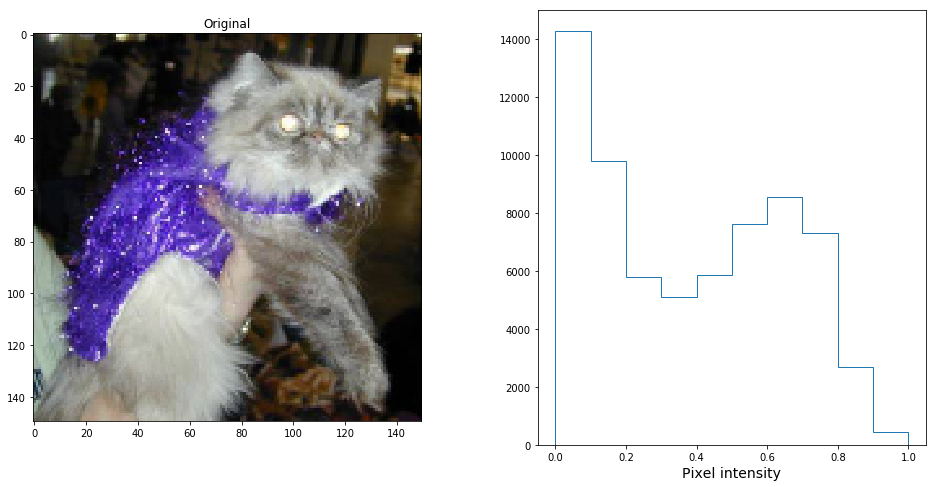

In [16]:
img = load_image('{}data/dogs_vs_cats/train/training_set/cat/cat.10013.jpg'.format(path), img_height, img_width)
show_image(img)
# actual image
cat_img_resized = image_resizing(img)
print(cat_img_resized.shape)

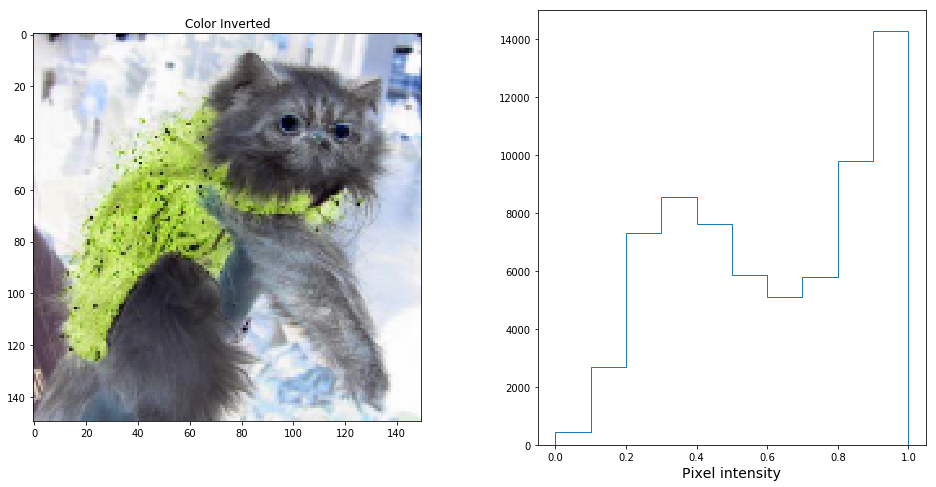

In [17]:
inverted_color_img = image_transformation(img, method_type='invert')
show_image(inverted_color_img, title='Color Inverted')
inverted_color_img = image_resizing(inverted_color_img)

In [18]:
sess = tf.Session()
K.set_session(sess)

In [19]:
from skater.util.logger import build_logger
from skater.util.logger import _INFO

input_x = np.array([cat_img_resized[0], inverted_color_img[0]])
K.set_learning_phase(0)
with DeepInterpreter(session=K.get_session()) as di:
    di.logger = build_logger(_INFO, __name__)
    # 1. Load the persisted model
    # 2. Retrieve the input tensor from the loaded model
    yaml_file = open('model_cats_dogs.yaml', 'r')
    loaded_model_yaml = yaml_file.read()
    yaml_file.close()
    loaded_model = model_from_yaml(loaded_model_yaml)
    # load weights into new model
    loaded_model.load_weights("model_cats_dogs.h5")
    print("Loaded model from disk")
    X = loaded_model.layers[0].input
    output_tensor = loaded_model.layers[-2].output
    
    # 3. We will using the last dense layer(pre-softmax) as the output layer
    xs = input_x
    print("X shape: {}".format(xs.shape))

    # Predicted Labels
    predictions = map(lambda x: loaded_model.predict_classes(x.reshape((1,) + x.shape)) , input_x)
    labels = map(lambda x: "dog" if x==1 else "cat", predictions)
    print("Predicted class Label: {}".format(list(labels)))
    
    # compute the relevance score
    # Computing relevance or attribution by perturbing the feature space using occlusion is computationally expensive
    # One might need to control the rolling window parameters (Height, Width, stepsize) manage computational resource
    # optional args for occlusion
    optional_args = {"window_size": 2, "step": 2}
    relevance_scores = {
        'integrated gradient': di.explain('ig', output_tensor, X, xs, use_case='image'),
        'e-LRP': di.explain('elrp', output_tensor, X, xs, use_case='image'),
        'occlusion': di.explain('occlusion', output_tensor, X, xs, use_case='image', **optional_args)
    }

Loaded model from disk
X shape: (2, 150, 150, 3)
1/1 [==============================] - 0s

2018-05-30 00:43:11,419 - __main__ - INFO - all supported relevancy scorers OrderedDict([('elrp', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP'>}), ('ig', {'use_case_type': ['image', 'txt'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients'>}), ('occlusion', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.perturbation_relevance_scorer.Occlusion'>})])
2018-05-30 00:43:11,420 - __main__ - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients'>
2018-05-30 00:43:11,421 - __main__ - INFO - DeepInterpreter: executing method <skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients object at 0x7ff75c289f60>
2018-05-30 00:43:11,422 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrate


Predicted class Label: ['dog', 'cat']


2018-05-30 00:43:14,479 - __main__ - INFO - all supported relevancy scorers OrderedDict([('elrp', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP'>}), ('ig', {'use_case_type': ['image', 'txt'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients'>}), ('occlusion', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.perturbation_relevance_scorer.Occlusion'>})])
2018-05-30 00:43:14,480 - __main__ - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP'>
2018-05-30 00:43:14,481 - LRP - INFO - Epsilon value: 0.0001
2018-05-30 00:43:14,482 - __main__ - INFO - DeepInterpreter: executing method <skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP object at 0x7ff75c289f60>
2018-05-30 00:43:14,482 - BaseGradientMethod - INFO - Executing operations ...
2018

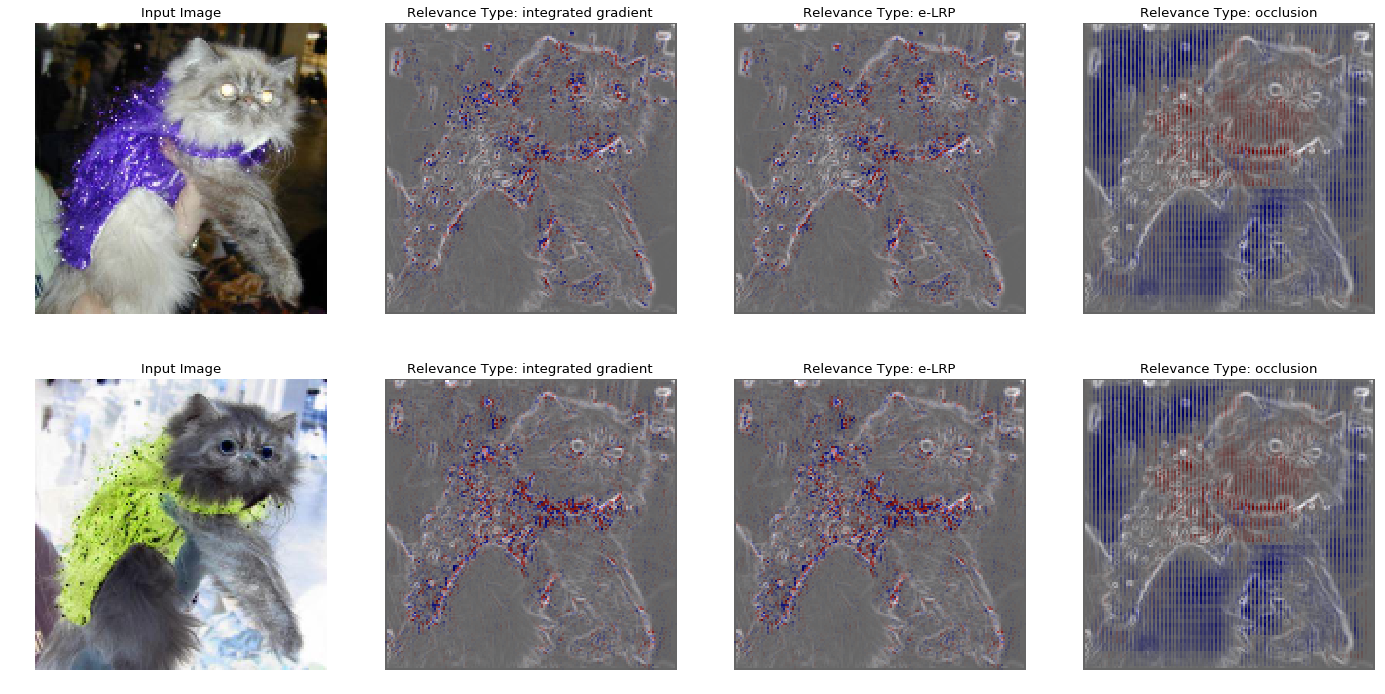

In [20]:
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 11

xs = input_x
n_cols = int(len(relevance_scores)) + 1
n_rows = len(input_x) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(xs):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Input Image')
    ax.axis('off')
    for j, r_type in enumerate(relevance_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevance_scores[r_type][i], original_input_img=xi, axis=axj, 
                  percentile=99, alpha_edges=1, alpha_bgcolor=0.4).set_title("Relevance Type: {}".format(r_type))

(1, 150, 150, 3)
1/1 [==============================] - 0s
Predicted Label: [[1.]]


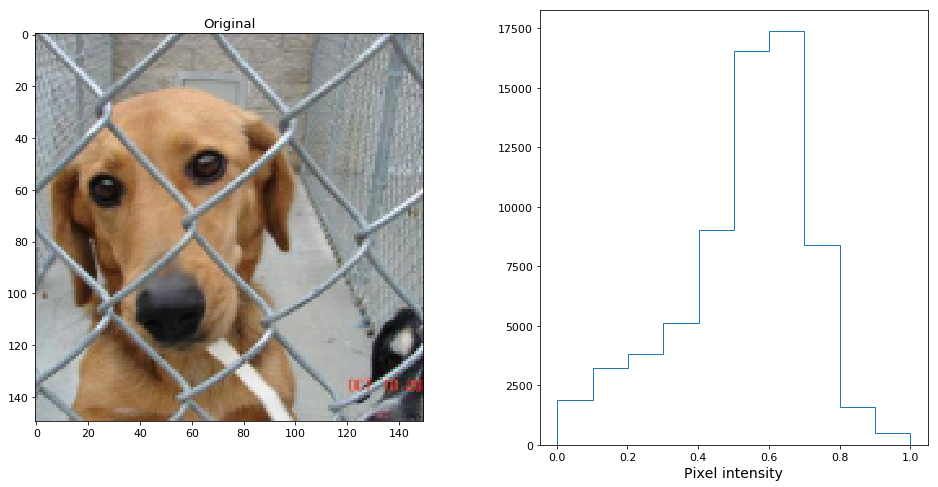

In [21]:
img = load_image('{}data/dogs_vs_cats/train/validation_set/dog/dog.2356.jpg'.format(path), img_height, img_width)
show_image(img)
# actual image
an_img = image_resizing(img)
print(an_img.shape)
# Request model for prediction
print("Predicted Label: {}".format(loaded_model.predict_proba(an_img)))

2018-05-30 00:44:15,833 - skater.util.image_ops - INFO - Number of pixels matching the condition : 51422
2018-05-30 00:44:15,834 - skater.util.image_ops - INFO - Number of pixels specified to be replaced : 50000


1/1 [==============================] - 0s
Predicted Label: [[1.]]


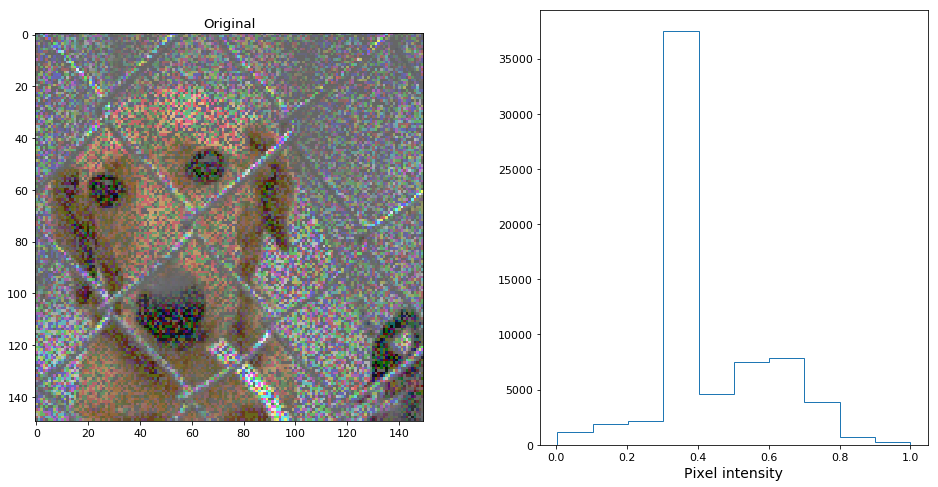

In [22]:
X = img
n_in_img = flip_pixels(img, 50000, filtered_pixel=in_between(X, 0.4, 0.8), replace_with=0.4)
show_image(n_in_img)

modified_img = image_resizing(n_in_img)
# Request model for prediction
print("Predicted Label: {}".format(loaded_model.predict_proba(modified_img)))

In [26]:
from skater.util.logger import build_logger
from skater.util.logger import _INFO

input_x = np.array([an_img[0], modified_img[0]])
K.set_learning_phase(0)
with DeepInterpreter(session=K.get_session()) as di:
    di.logger = build_logger(_INFO, __name__)
    # 1. Load the persisted model
    # 2. Retrieve the input tensor from the loaded model
    yaml_file = open('model_cats_dogs.yaml', 'r')
    loaded_model_yaml = yaml_file.read()
    yaml_file.close()
    loaded_model = model_from_yaml(loaded_model_yaml)
    # load weights into new model
    loaded_model.load_weights("model_cats_dogs.h5")
    print("Loaded model from disk")
    X = loaded_model.layers[0].input
    output_tensor = loaded_model.layers[-2].output
    
    # 3. We will using the last dense layer(pre-softmax) as the output layer
    xs = input_x
    print("X shape: {}".format(xs.shape))
    
    # Predicted Labels
    predictions = map(lambda x: loaded_model.predict_classes(x.reshape((1,) + x.shape)) , input_x)
    labels = map(lambda x: "dog" if x==1 else "cat", predictions)
    print("Predicted class Label: {}".format(list(labels)))

    optional_args = {"window_size": 2, "step": 1}
    relevance_scores = {
        'integrated gradient': di.explain('ig', output_tensor, X, xs, use_case='image'),
        'e-LRP': di.explain('elrp', output_tensor, X, xs, use_case='image'),
        # applying perturbation is computationally expensive and depends on feature space
        'occlusion': di.explain('occlusion', output_tensor, X, xs, use_case='image', **optional_args)
    }

Loaded model from disk
X shape: (2, 150, 150, 3)
1/1 [==============================] - 0s

2018-05-30 00:47:15,206 - __main__ - INFO - all supported relevancy scorers OrderedDict([('elrp', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP'>}), ('ig', {'use_case_type': ['image', 'txt'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients'>}), ('occlusion', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.perturbation_relevance_scorer.Occlusion'>})])
2018-05-30 00:47:15,207 - __main__ - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients'>
2018-05-30 00:47:15,208 - __main__ - INFO - DeepInterpreter: executing method <skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients object at 0x7ff74c0e7a90>
2018-05-30 00:47:15,209 - IntegratedGradients - INFO - Executing operations to compute relevance using Integrate


Predicted class Label: ['dog', 'dog']


2018-05-30 00:47:18,303 - __main__ - INFO - all supported relevancy scorers OrderedDict([('elrp', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP'>}), ('ig', {'use_case_type': ['image', 'txt'], 'method': <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.IntegratedGradients'>}), ('occlusion', {'use_case_type': ['image'], 'method': <class 'skater.core.local_interpretation.dnni.perturbation_relevance_scorer.Occlusion'>})])
2018-05-30 00:47:18,303 - __main__ - INFO - DeepInterpreter: executing relevance type class <class 'skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP'>
2018-05-30 00:47:18,304 - LRP - INFO - Epsilon value: 0.0001
2018-05-30 00:47:18,305 - __main__ - INFO - DeepInterpreter: executing method <skater.core.local_interpretation.dnni.gradient_relevance_scorer.LRP object at 0x7ff74c0f34a8>
2018-05-30 00:47:18,306 - BaseGradientMethod - INFO - Executing operations ...
2018

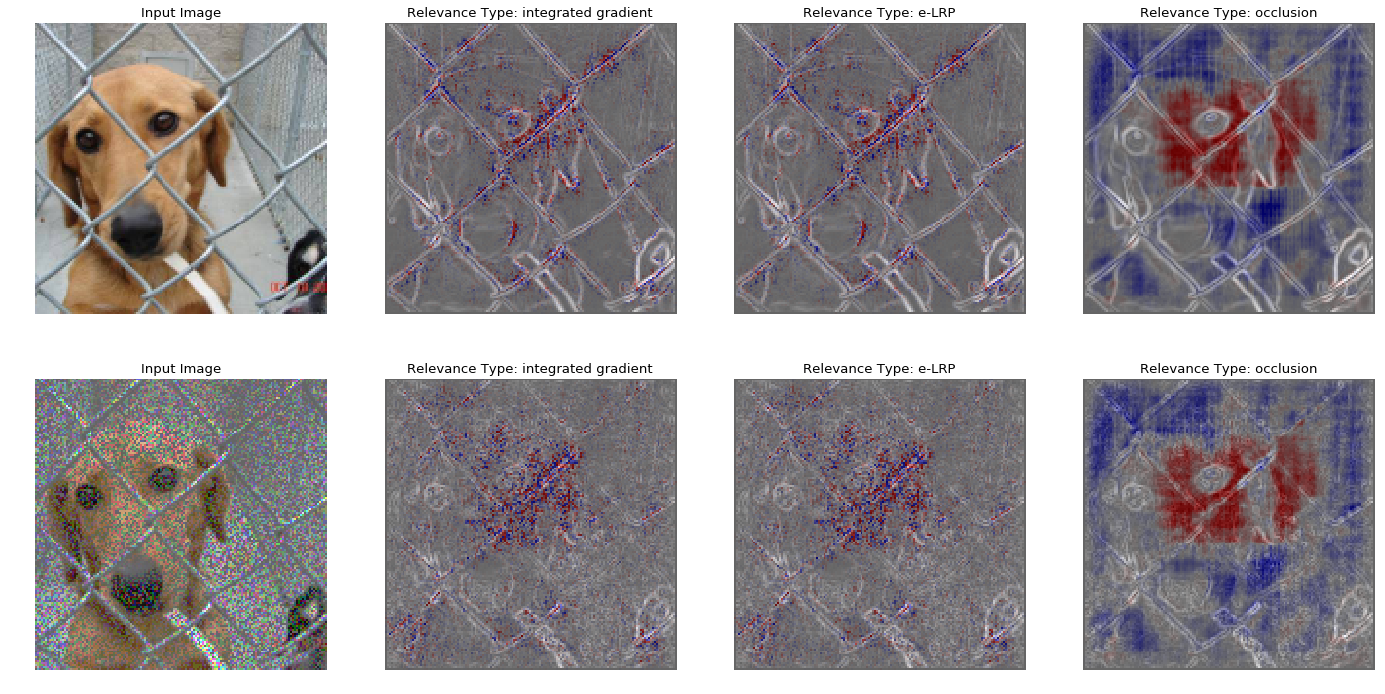

In [27]:
# visualize relevance
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 11

n_cols = int(len(relevance_scores)) + 1
n_rows = len(input_x) 
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 6*n_rows))

for i, xi in enumerate(input_x):
    ax = axes.flatten()[i*n_cols]
    ax.imshow(xi)
    ax.set_title('Input Image')
    ax.axis('off')
    for j, r_type in enumerate(relevance_scores):
        axj = axes.flatten()[i*n_cols + j + 1]
        visualize(relevance_scores[r_type][i], original_input_img=xi, axis=axj, 
                  percentile=99, alpha_edges=1, alpha_bgcolor=0.4).set_title("Relevance Type: {}".format(r_type))